# DKGPR

This notebook demonstrates how to use the DKGPR for Microscopy-Spectroscopy

**Author:** Yongtao Liu 

**Date:** January 2026

## Import

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Import DKGP
from dkgp import fit_dkgp, predict
from dkgp.acquisition import (
    expected_improvement,
    upper_confidence_bound,
    probability_of_improvement)


/Users/yla/ORNL Dropbox/Yongtao Liu/MyFiles/CNMS_2025/Githublocal/DKGP/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## Helper function

"""The loop area of the hysteresis curve is related to:
 --Strength of ferroelectric switching
 --Energy dissipation during polarization reversal
 --Quality of the ferroelectric material at that location"""

def loop_area(raw_spec, cycle):
    """Calculate loop area from spectrum."""
    raw_spec_len = len(raw_spec)
    cycle_len = int(raw_spec_len / cycle)
    half_len = int(cycle_len / 2)
    q_len = int(cycle_len / 4)
    loop_top, loop_bottom = [], []
    loop_top.append(raw_spec[q_len : q_len + half_len])
    loop_top.append(raw_spec[q_len + 2*half_len : q_len + 3*half_len])
    loop_top.append(raw_spec[q_len + 4*half_len : 2*q_len + 4*half_len])
    loop_bottom.append(raw_spec[:q_len])
    loop_bottom.append(raw_spec[q_len + half_len: q_len + 2*half_len])
    loop_bottom.append(raw_spec[q_len + 3*half_len: q_len + 4*half_len])
    loop_top = np.concatenate(loop_top)
    loop_bottom = np.concatenate(loop_bottom)
    return np.abs(np.sum(loop_top) - np.sum(loop_bottom))

norm_ = lambda x: (x - x.min()) / np.ptp(x)

def get_grid_coords (img, step=1):
    """
    Generate coordinate grid for a single 2D image.
    
    Args:
        img: 2D numpy array
        step: distance between grid points
    
    Returns:
        N x 2 array of (y, x) coordinates
    """
    h, w = img.shape[:2]
    coords = []
    for i in range(0, h, step):
        for j in range(0, w, step):
            coords.append([i, j])
    return np.array(coords)


def get_subimages(img, coordinates, window_size):
    """
    Extract subimages centered at given coordinates.
    
    Args:
        img: 2D or 3D numpy array (h, w) or (h, w, c)
        coordinates: N x 2 array of (y, x) coordinates
        window_size: size of square window to extract
    
    Returns:
        subimages: (N, window_size, window_size, channels) array
        valid_coords: coordinates where extraction succeeded
        valid_indices: indices of valid extractions
    """
    if img.ndim == 2:
        img = img[..., None]
    
    h, w, c = img.shape
    half_w = window_size // 2
    
    subimages = []
    valid_coords = []
    valid_indices = []
    
    for idx, (y, x) in enumerate(coordinates):
        # Check boundaries
        if (y - half_w >= 0 and y + half_w <= h and
            x - half_w >= 0 and x + half_w <= w):
            
            patch = img[y - half_w:y + half_w,
                       x - half_w:x + half_w, :]
            
            if patch.shape[0] == window_size and patch.shape[1] == window_size:
                subimages.append(patch)
                valid_coords.append([y, x])
                valid_indices.append(idx)
    
    return (np.array(subimages), 
            np.array(valid_coords), 
            np.array(valid_indices))

### Load Data

In [4]:
bepsdata = np.load("/Users/yla/Documents/BEPS_PTO_1d7um.npz")
amp_off_field = bepsdata['amp_off_field']
pha_off_field = bepsdata['pha_off_field']
v_step = bepsdata['v_step']

pola_off_field = amp_off_field * np.cos(pha_off_field)*1e3

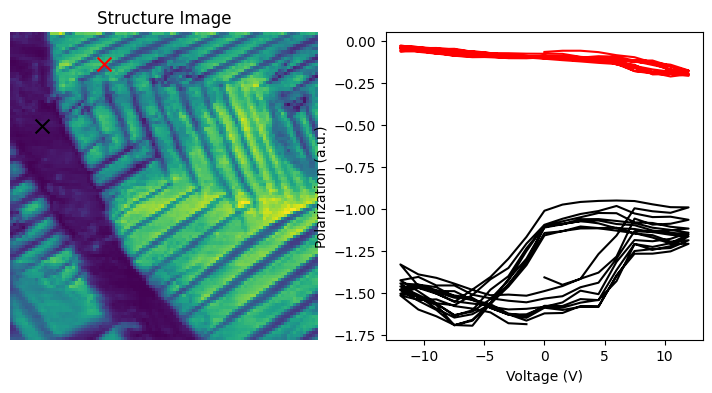

In [5]:
# select a region for exploration
exp_data = pola_off_field
img_data = amp_off_field
struc_img = img_data.mean(2)

# Visualize
plot_pixx1, plot_pixy1 = 10, 30
plot_pixx2, plot_pixy2 = 30, 10

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(struc_img)
ax1.scatter(plot_pixx1, plot_pixy1, marker='x', s=100, c='k')
ax1.scatter(plot_pixx2, plot_pixy2, marker='x', s=100, c='r')
ax1.set_title('Structure Image')
ax1.axis("off")

ax2.plot(v_step, exp_data[plot_pixx1, plot_pixy1], c='k')
ax2.plot(v_step, exp_data[plot_pixx2, plot_pixy2], c='r')
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('Polarization (a.u.)')

plt.show()

In [6]:
# Extract image patches and spectra
img = norm_(struc_img)
spectra = norm_(exp_data)

coordinates = get_grid_coords(img, step=1)
window_size = 16
features_all, coords, _ = get_subimages(img, coordinates, window_size)
features_all = features_all[:,:,:,0]
coords = np.array(coords, dtype=int)
targets = spectra[coords[:, 0], coords[:, 1]]

print('Coordinates shape:', coords.shape)
print('Image patches shape:', features_all.shape)
print('Spectra shape:', spectra.shape)
print('Target spectra shape:', targets.shape)

Coordinates shape: (7225, 2)
Image patches shape: (7225, 16, 16)
Spectra shape: (100, 100, 256)
Target spectra shape: (7225, 256)


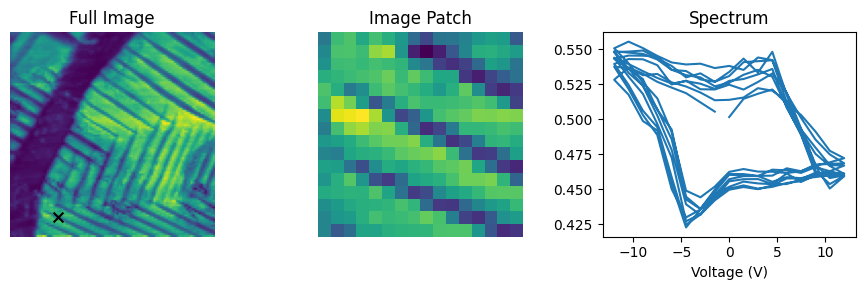

In [7]:
# Visualize example patch
k_example = 100
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), dpi=100)
ax1.imshow(img, origin='lower')
ax1.scatter(coords[k_example, 1], coords[k_example, 0], marker='x', s=50, c='k')
ax1.axis("off")
ax1.set_title('Full Image')

ax2.imshow(features_all[k_example], origin='lower')
ax2.axis("off")
ax2.set_title('Image Patch')

ax3.plot(v_step, spectra[coords[k_example, 0], coords[k_example, 1]])
ax3.set_title('Spectrum')
ax3.set_xlabel('Voltage (V)')
plt.tight_layout()
plt.show()

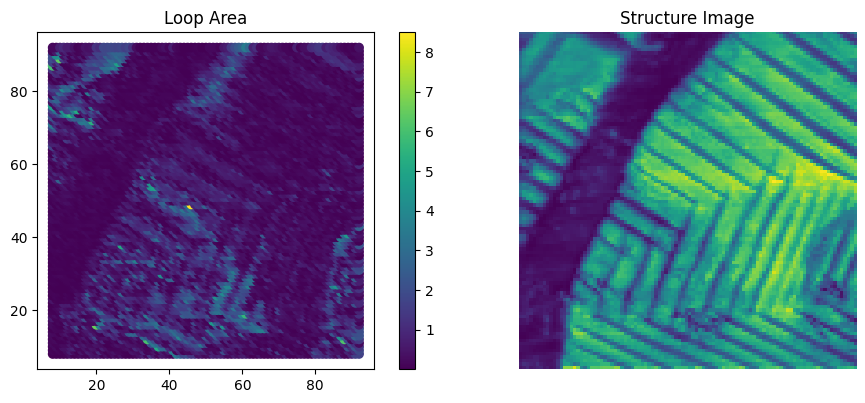

In [8]:
# Normalize and compute loop areas
features = norm_(features_all)
targets = norm_(targets)

loop_areas_all = []
for i, t in enumerate(targets):
    looparea = loop_area(t, 3)
    loop_areas_all.append(np.array([looparea]))

loop_areas_all = np.concatenate(loop_areas_all)

# Visualize loop areas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
a = ax1.scatter(coords[:, 1], coords[:, 0], c=loop_areas_all, cmap='viridis')
plt.colorbar(a, ax=ax1)
ax1.set_title('Loop Area')
ax1.set_aspect('equal')

ax2.imshow(struc_img, origin="lower")
ax2.set_title('Structure Image')
ax2.axis("off")
plt.tight_layout()
plt.show()

In [9]:
# Prepare data arrays
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)  # Flattened patches for DKL
y = norm_(loop_areas_all)  # Scalarized values

print(f"X_train shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Coords shape: {coords.shape}")

X_train shape: (7225, 256)
y shape: (7225,)
Coords shape: (7225, 2)


In [15]:
# Select initial training points
np.random.seed(5)
start_size = 20
train_indices = np.random.choice(np.arange(1, n), size=start_size, replace=False)

X_train = X[train_indices]
y_train = y[train_indices]
coord_train = coords[train_indices]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Coordinates shape: {coord_train.shape}")

X_train shape: (20, 256)
y_train shape: (20,)
Coordinates shape: (20, 2)


In [20]:
# Train Deep Kernel GP
mll, gp_model, dkl_model, losses = fit_dkgp(
    X_train,
    y_train,
    feature_dim=8,           # Reduce 100D -> 16D
    extractor_type = 'attention',    # Fully connected extractor
    num_epochs=2000,          # Training iterations
    verbose=True      
)

Training Deep Kernel GP Regression Model
Feature Extractor: attention

Auto-selected: ExactMarginalLogLikelihood

Training Deep Kernel GP
  Device: cpu
  Extractor type: attention
  Input dim: 256 → Feature dim: 8
  Data points: 20
  Hidden layers: [256, 128, 64]
  MLL: ExactMarginalLogLikelihood
  Epoch  100/2000, Loss: 0.4461
  Epoch  200/2000, Loss: -0.0241
  Epoch  300/2000, Loss: -0.5180
  Epoch  400/2000, Loss: -1.0339
  Epoch  500/2000, Loss: -1.4899
  Epoch  600/2000, Loss: -1.9133
  Epoch  700/2000, Loss: -2.2893
  Epoch  800/2000, Loss: -2.5609
  Epoch  900/2000, Loss: -2.7475
  Epoch 1000/2000, Loss: -2.8574
  Epoch 1100/2000, Loss: -2.9261
  Epoch 1200/2000, Loss: -2.9855
  Epoch 1300/2000, Loss: -3.0237
  Epoch 1400/2000, Loss: -3.0494
  Epoch 1500/2000, Loss: -3.0702
  Epoch 1600/2000, Loss: -3.0836
  Epoch 1700/2000, Loss: -3.0940
  Epoch 1800/2000, Loss: -3.1027
  Epoch 1900/2000, Loss: -3.1110
  Epoch 2000/2000, Loss: -3.1171
Training complete! Final loss: -3.1171


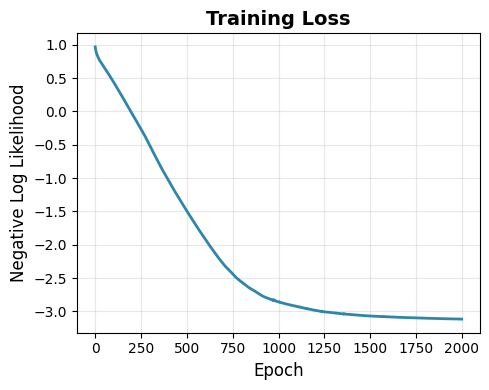

Final loss: -3.1171


In [21]:
plt.figure(figsize=(5, 4))

plt.subplot()
plt.plot(losses, linewidth=2, color='#2E86AB')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Negative Log Likelihood', fontsize=12)
plt.title('Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final loss: {losses[-1]:.4f}")

In [22]:
# Predict on test set
mean_pred, std_pred = predict(dkl_model, X, return_std=True)

print(f"Predictions shape: {mean_pred.shape}")
print(f"Uncertainty shape: {std_pred.shape}")
print(f"Mean uncertainty: {std_pred.mean():.4f}")

Predictions shape: (7225,)
Uncertainty shape: (7225,)
Mean uncertainty: 0.1034


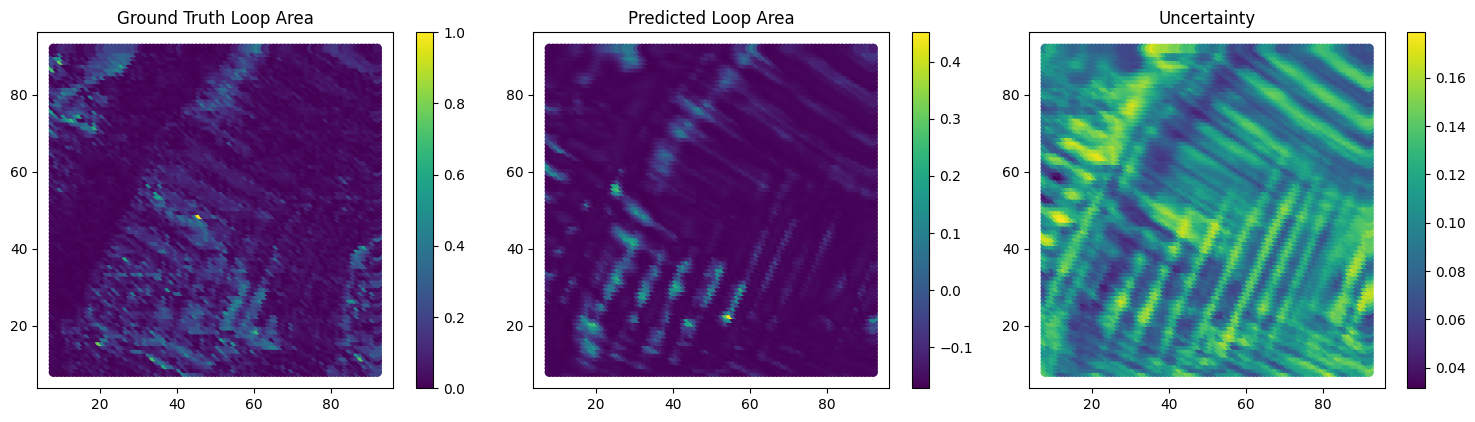

In [23]:
# Visualize loop areas
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
a = ax1.scatter(coords[:, 1], coords[:, 0], c=y, cmap='viridis')
plt.colorbar(a, ax=ax1)
ax1.set_title('Ground Truth Loop Area')
ax1.set_aspect('equal')

b=ax2.scatter(coords[:, 1], coords[:, 0], c=mean_pred, cmap='viridis')
ax2.set_title('Predicted Loop Area')
plt.colorbar(b, ax=ax2)
ax2.set_aspect('equal')

c=ax3.scatter(coords[:, 1], coords[:, 0], c=std_pred, cmap='viridis')
ax3.set_title('Uncertainty')
plt.colorbar(c, ax=ax3)
ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

### Define Test Function

In [ ]:
def branin_high_dim(x):
    """
    Branin function (classic optimization benchmark) in high dimensions.
    Only first 2 dimensions matter, rest are noise.
    Global minimum ≈ 0.398 at (π, 2.275) and two other locations.
    """
    x1 = x[0] * 15 - 5   # Scale to [-5, 10]
    x2 = x[1] * 15        # Scale to [0, 15]
    
    a = 1
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    
    term1 = a * (x2 - b * x1**2 + c * x1 - r)**2
    term2 = s * (1 - t) * np.cos(x1)
    term3 = s
    
    # Add small noise from other dimensions
    if len(x) > 2:
        noise = 0.05 * np.sum(x[2:]**2)
    else:
        noise = 0
    
    return term1 + term2 + term3 + noise

print(f"True global minimum: ≈ 0.398")
print(f"Test evaluation: {branin_high_dim(np.array([0.5424, 0.1517] + [0]*18)):.4f}")

### Initialize with Random Samples

In [ ]:
# Problem setup
input_dim = 20
n_initial = 10
n_iterations = 15

# Generate candidate pool
n_candidates = 2000
candidates = np.random.uniform(0, 1, size=(n_candidates, input_dim))

# Initial random samples
initial_idx = np.random.choice(n_candidates, n_initial, replace=False)
X_observed = candidates[initial_idx]
y_observed = np.array([branin_high_dim(x) for x in X_observed])

print(f"Initial samples: {n_initial}")
print(f"Initial best: {y_observed.min():.4f}")
print(f"Candidate pool: {n_candidates} points")

### Run Bayesian Optimization Loop

In [ ]:
# Track progress
best_values = [y_observed.min()]
all_values = list(y_observed)
ei_values_history = []

print("Starting Bayesian Optimization...\n")
print(f"{'Iter':<6} {'Next f(x)':<12} {'Best f(x)':<12} {'Max EI':<12}")
print("="*48)

for iteration in range(n_iterations):
    # Train model on current observations
    _, _, model, _ = fit_dkgp(
        X_observed,
        y_observed,
        feature_dim=16,
        num_epochs=500,
        verbose=False
    )
    
    # Get current best
    best_f = y_observed.min()
    
    # Remove already evaluated candidates
    mask = np.ones(len(candidates), dtype=bool)
    for x in X_observed:
        mask &= ~np.all(np.isclose(candidates, x), axis=1)
    available = candidates[mask]
    
    # Compute Expected Improvement
    ei = expected_improvement(
        model,
        available,
        best_f=best_f,
        xi=0.01,
        maximize=False  # Minimize Branin
    )
    
    # Select next point
    next_idx = np.argmax(ei)
    next_point = available[next_idx]
    next_value = branin_high_dim(next_point)
    
    # Update observations
    X_observed = np.vstack([X_observed, next_point])
    y_observed = np.append(y_observed, next_value)
    
    # Track progress
    best_values.append(y_observed.min())
    all_values.append(next_value)
    ei_values_history.append(ei.max())
    
    print(f"{iteration+1:<6} {next_value:<12.4f} {y_observed.min():<12.4f} {ei.max():<12.6f}")

print("="*48)
print(f"\nOptimization complete!")
print(f"Final best value: {y_observed.min():.4f}")
print(f"True global minimum: 0.398")
print(f"Gap: {y_observed.min() - 0.398:.4f}")

### Visualize Optimization Progress

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Best value over iterations
axes[0, 0].plot(best_values, 'o-', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].axhline(y=0.398, color='r', linestyle='--', linewidth=2, label='Global minimum')
axes[0, 0].set_xlabel('Iteration', fontsize=12)
axes[0, 0].set_ylabel('Best f(x) Found', fontsize=12)
axes[0, 0].set_title('Optimization Progress', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. All evaluations
axes[0, 1].plot(all_values, 'o', alpha=0.6, markersize=6, color='#A23B72')
axes[0, 1].axhline(y=0.398, color='r', linestyle='--', linewidth=2, label='Global minimum')
axes[0, 1].axvline(x=n_initial-0.5, color='k', linestyle=':', linewidth=2, label='Initial samples')
axes[0, 1].set_xlabel('Evaluation', fontsize=12)
axes[0, 1].set_ylabel('f(x)', fontsize=12)
axes[0, 1].set_title('All Evaluations', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Expected Improvement over iterations
axes[1, 0].plot(ei_values_history, 's-', linewidth=2, markersize=7, color='#F18F01')
axes[1, 0].set_xlabel('Iteration', fontsize=12)
axes[1, 0].set_ylabel('Max Expected Improvement', fontsize=12)
axes[1, 0].set_title('Acquisition Function Values', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Cumulative improvement
improvements = np.maximum.accumulate(-np.array(best_values))  # Negative for minimization
axes[1, 1].plot(improvements, 'o-', linewidth=2, markersize=8, color='#C73E1D')
axes[1, 1].set_xlabel('Iteration', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Improvement', fontsize=12)
axes[1, 1].set_title('Total Improvement Over Initial Best', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Compare Acquisition Functions

In [ ]:
# Train final model
_, _, final_model, _ = fit_dkgp(
    X_observed, y_observed,
    feature_dim=16,
    num_epochs=500,
    verbose=False
)

# Sample some test candidates
test_candidates = np.random.uniform(0, 1, (100, input_dim))
best_f = y_observed.min()

# Compute different acquisition functions
ei = expected_improvement(final_model, test_candidates, best_f, maximize=False)
ucb = upper_confidence_bound(final_model, test_candidates, beta=2.0, maximize=False)
pi = probability_of_improvement(final_model, test_candidates, best_f, maximize=False)

# Normalize for comparison
ei_norm = (ei - ei.min()) / (ei.max() - ei.min() + 1e-8)
ucb_norm = (ucb - ucb.min()) / (ucb.max() - ucb.min() + 1e-8)
pi_norm = (pi - pi.min()) / (pi.max() - pi.min() + 1e-8)

# Plot
plt.figure(figsize=(12, 4))

x = np.arange(len(test_candidates))
width = 0.25

plt.bar(x - width, ei_norm, width, label='EI', alpha=0.8)
plt.bar(x, ucb_norm, width, label='UCB', alpha=0.8)
plt.bar(x + width, pi_norm, width, label='PI', alpha=0.8)

plt.xlabel('Candidate Index', fontsize=12)
plt.ylabel('Normalized Acquisition Value', fontsize=12)
plt.title('Comparison of Acquisition Functions', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Show top candidates for each
print("\nTop 3 candidates by acquisition function:")
print(f"  EI:  indices {np.argsort(ei)[-3:][::-1]}")
print(f"  UCB: indices {np.argsort(ucb)[:3]}")
print(f"  PI:  indices {np.argsort(pi)[-3:][::-1]}")